In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
dtype=dict(MONTH=np.int32, DAY_OF_WEEK=np.int32, FL_NUM=np.int32)

df = pd.read_csv("data/reduced-aggregated.csv", dtype=dtype)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570274 entries, 0 to 570273
Data columns (total 14 columns):
MONTH               570274 non-null int32
DAY_OF_WEEK         570274 non-null int32
FL_DATE             570274 non-null object
UNIQUE_CARRIER      570274 non-null object
FL_NUM              570274 non-null int32
ORIGIN              570274 non-null object
ORIGIN_CITY_NAME    570274 non-null object
DEST                570274 non-null object
DEST_CITY_NAME      570274 non-null object
CRS_DEP_TIME        570274 non-null float64
ARR_DEL15           562422 non-null float64
CRS_ELAPSED_TIME    570274 non-null float64
DISTANCE            570274 non-null float64
Unnamed: 13         0 non-null float64
dtypes: float64(5), int32(3), object(6)
memory usage: 54.4+ MB


In [5]:
df.head(10)

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13
0,2,5,2017-02-03,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
1,2,7,2017-02-12,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,1.0,90.0,266.0,NaN
2,2,1,2017-02-13,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,1.0,90.0,266.0,NaN
3,2,1,2017-02-27,B6,33,DCA,"Washington, DC",PBI,"West Palm Beach/Palm Beach, FL",1730.0,0.0,157.0,857.0,NaN
4,2,2,2017-02-14,B6,34,JFK,"New York, NY",BTV,"Burlington, VT",1706.0,0.0,81.0,266.0,NaN
5,2,5,2017-02-17,B6,34,PBI,"West Palm Beach/Palm Beach, FL",DCA,"Washington, DC",2045.0,0.0,133.0,857.0,NaN
6,2,6,2017-02-18,B6,34,PBI,"West Palm Beach/Palm Beach, FL",DCA,"Washington, DC",2045.0,0.0,133.0,857.0,NaN
7,2,1,2017-02-27,B6,34,PBI,"West Palm Beach/Palm Beach, FL",DCA,"Washington, DC",2045.0,0.0,133.0,857.0,NaN
8,2,3,2017-02-01,B6,42,LGB,"Long Beach, CA",RNO,"Reno, NV",912.0,0.0,87.0,402.0,NaN
9,2,5,2017-02-10,B6,42,LGB,"Long Beach, CA",RNO,"Reno, NV",912.0,0.0,87.0,402.0,NaN


One hot encode:
* MONTH
* DAY_OF_WEEK
* UNIQUE_CARRIER
* ORIGIN
* ORIGIN_CITY_NAME
* DEST
* DEST_CITY_NAME

KBinsDiscretizer
* CRS_DEP_TIME

Dont change
* DISTANCE
* CRS_ELAPSED_TIME

Break up
* FL_DATE
    * Extract year
    * Extract week

Unknown
* FL_NUM

In [12]:
def clean_data(df, oe_dict=None): 
    columns = ['Unnamed: 13', 'UNIQUE_CARRIER', 'ORIGIN',
               'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME']

    # Encode columns
    new_oe = False
    if oe_dict == None:
        new_oe = True
        
    if oe_dict == None:
        oe_dict =\
            {'UNIQUE_CARRIER': OneHotEncoder(categories='auto', dtype=np.int8),
             'ORIGIN': OneHotEncoder(categories='auto', dtype=np.int8),
             'ORIGIN_CITY_NAME': OneHotEncoder(categories='auto', dtype=np.int8),
             'DEST': OneHotEncoder(categories='auto', dtype=np.int8),
             'DEST_CITY_NAME': OneHotEncoder(categories='auto', dtype=np.int8)}
        
    for col, oe in oe_dict.items():
        if new_oe:
            X = oe.fit_transform(df[col].values.reshape(-1,1)).toarray()
        else:
            X = oe.transform(df[col].values.reshape(-1,1)).toarray()
        features = np.array(oe.categories_).ravel()
        dfOneHot = pd.DataFrame(X, columns=features)
        df = pd.concat([df, dfOneHot], axis=1)


    df = df.drop(columns=columns)
    
    #

    return df, oe_dict

In [13]:
clean_df = clean_data(df)

In [15]:
clean_df.shape

(570274, 1250)

In [14]:
clean_df.head(10)

,MONTH,DAY_OF_WEEK,FL_DATE,FL_NUM,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,AA,AS,...,"West Yellowstone, MT","White Plains, NY","Wichita Falls, TX","Wichita, KS","Williston, ND","Wilmington, NC","Worcester, MA","Wrangell, AK","Yakutat, AK","Yuma, AZ"
0,2,5,2017-02-03,33,1907.0,0.0,90.0,266.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,7,2017-02-12,33,1907.0,1.0,90.0,266.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,2017-02-13,33,1907.0,1.0,90.0,266.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,2017-02-27,33,1730.0,0.0,157.0,857.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,2017-02-14,34,1706.0,0.0,81.0,266.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,5,2017-02-17,34,2045.0,0.0,133.0,857.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2,6,2017-02-18,34,2045.0,0.0,133.0,857.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2,1,2017-02-27,34,2045.0,0.0,133.0,857.0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2,3,2017-02-01,42,912.0,0.0,87.0,402.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2,5,2017-02-10,42,912.0,0.0,87.0,402.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df.nunique()

MONTH                 11
DAY_OF_WEEK            7
FL_DATE              334
UNIQUE_CARRIER        12
FL_NUM              6774
ORIGIN               309
ORIGIN_CITY_NAME     305
DEST                 310
DEST_CITY_NAME       306
CRS_DEP_TIME        1289
ARR_DEL15              2
CRS_ELAPSED_TIME     546
DISTANCE            1331
Unnamed: 13            0
dtype: int64

In [18]:
df.FL_NUM.unique()

array([  33.,   34.,   42., ..., 4975., 6512., 4943.])

In [21]:
plt.rcParams['figure.figsize'] = [10, 10]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f747da2b320>,
      dtype=object)

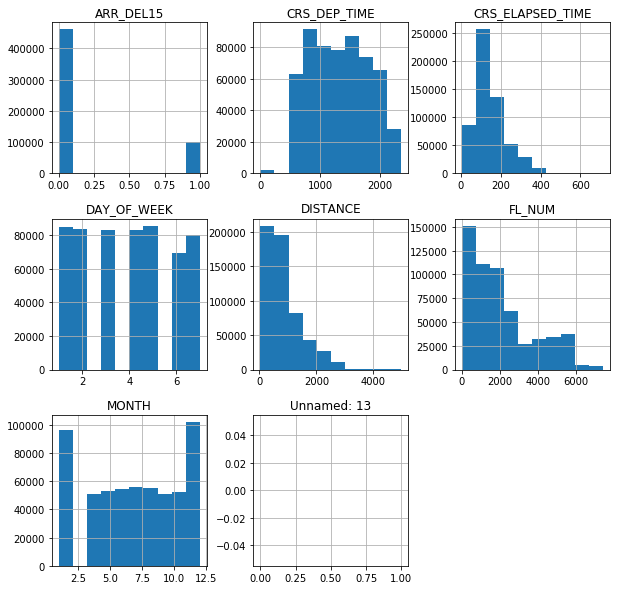

In [22]:
df.hist()